In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif

### Intro

This notebook will focus on the relationship between one's facial movements and the note in which they are singing. For instance, by purely examining the positioning of one's face without audio is it possible to identify how high a pitch they are singing? I will attempt to create and score machine learning models to explore this relationship. Secondly, I will look into what facial landmarks are the strongest indicators of pitch to identify what facial features change or strain the most as one sings different notes.

### Dataset Overview

Each participant was filmed with both computer and phone video while singing a specific series of phrases at different pitches. There were over 700 features extracted for the entire dataset, but we will just focus on the mic pitch and facial landmarks that will be used.

There were four different types of phrases (simple, vowel, sustained and glissando), and for each of these  the participant sang the phrase in roughly a dozen pitches working their way up from low to high. Then this process was repeated 14 times with differing recording postures and phonations such as breathy vs non breathy singing and hunched back vs correct posture. Here, I just focus on one participant's dataset who is in the intermediate experience level, but in the future it would be possible to verify the findings on additional participant data that was taken.

The mic pitch feature was created using the Crepe software platform to extract the microphone audio's pitch each 10ms of singing data. The facial landmark features were simultaneously extracted using dlib on both the phone video and computer video. For each source, the platform identified 68 points on the face and tracked each of their movement at the same interval of every 10ms.

### Import dataset

In [2]:
df2 = pd.read_csv('Output.csv')

#inspect dataset shape
print (df2.shape)

#inspect dataset
df2.head()

(60653, 702)


,participant_number,sex,age,experience_level,phonation,recording_condition,phrase,clip_number,mic_pitch,mic_note,...,computer_face_landmark_67_x,computer_face_landmark_67_y,computer_face_landmark_67_z,computer_face_landmark_68_x,computer_face_landmark_68_y,computer_face_landmark_68_z,RESPIRATION_1,EMG_1,EEG_1,EEG_2
0,9,F,25,intermediate,breathy,correct,glissando,3,203.04004,G#3,...,1063.0,234.0,NaN,1059.0,233.0,NaN,19070,32657,29783,33826
1,9,F,25,intermediate,breathy,correct,glissando,3,206.55988,G#3,...,1063.0,234.0,NaN,1059.0,234.0,NaN,19920,32554,30375,35826
2,9,F,25,intermediate,breathy,correct,glissando,3,210.76816,G#3,...,1063.0,234.0,NaN,1059.0,234.0,NaN,20705,32792,32543,33390
3,9,F,25,intermediate,breathy,correct,glissando,3,211.93843,G#3,...,1063.0,234.0,NaN,1059.0,233.0,NaN,21202,33015,34188,34910
4,9,F,25,intermediate,breathy,correct,glissando,3,210.22719,G#3,...,1063.0,234.0,NaN,1059.0,233.0,NaN,21460,32644,32725,31375


In [3]:
total_null_values = df2.isnull().sum().sum()
print(f"Total number of null values in the dataset: {total_null_values}")

pct_null = total_null_values/(df2.shape[0] * df2.shape[1]) * 100
print (f'This is {pct_null} % of all values')

Total number of null values in the dataset: 8708202
This is 20.452155959055865 % of all values


Upon inspection, I noticed that all the landmark values for the z direction are missing data and have null for the entire column besides phone pose and computer pose, because the software was unable to extract a third dimension in these cases. So I will delete these columns and ensure that there are fewer null values.


In [4]:
list_columns = df2.columns.to_list()

bad_cols = []

#create a list of all columns that end in z and are not pose landmarks
for col in list_columns:
    if col[-1] == 'z' and not 'pose' in col:
        bad_cols.append(col)

#drop bad columns
df2 = df2.drop(columns=bad_cols)

#print number of null values
total_null_values = df2.isnull().sum().sum()
print(f"Total number of null values in the dataset: {total_null_values}")

pct_null = total_null_values/(df2.shape[0] * df2.shape[1]) * 100
print (f'This is {pct_null} % of all values')

Total number of null values in the dataset: 459394
This is 1.3381863661788291 % of all values


# Classifying pitch based on face landmarks

Can looking at one's facial position determine how high a note they are singing?

### Determine what to classify

First explore the "note" category for a possible classification target. These are all the mic notes we are working with

In [5]:
unique_notes = df2['mic_note'].unique()

# Print unique notes
print(unique_notes)

['G#3' 'G3' 'A3' 'A#3' 'B3' 'C4' 'C#4' 'D4' 'D#4' 'E4' 'F4' 'F#4' 'G4'
 'G#4' 'A4' 'A#4' 'B4' 'F#3' 'F3' 'E3' 'C5' 'G6' 'C#5' 'D5' 'G#6' 'A6'
 'F#6' 'D#5' 'C1' 'C#1' 'D#1' 'B2' 'F1' 'A1' 'F#1' 'E1' 'C3' 'G#1' 'G#2'
 'A#1' 'C#2' 'E5' 'D3' 'D#3' 'A#2' 'E6']


Since there are a ton of notes for classification this would be a tough target, instead let's pull out the pitch of the note and create categories that classify groupings of pitches. I will create four groupings of pitch levels, each with 25% of the data.

In [6]:
pitches = df2['mic_pitch']

#define cutoff point for each percentile
first_quartile = np.percentile(pitches, 25)
second_quartile = np.median(pitches)
third_quartile = np.percentile(pitches, 75)

def group_pitches(pitch):
    '''
    Function takes in an integer (pitch), sorts it into which quartile it belongs to, and returns a string
    indicating that quartile.
    '''
    if pitch <= first_quartile:
        return "low"
    elif pitch <= second_quartile:
        return "medium low"
    elif pitch <= third_quartile:
        return "medium high"
    else: return "high"

#create new pitch column with a categorical phrase that describes the height of the pitch
df2["Pitch"] = df2['mic_pitch'].apply(group_pitches)

df2


,participant_number,sex,age,experience_level,phonation,recording_condition,phrase,clip_number,mic_pitch,mic_note,...,computer_face_landmark_66_y,computer_face_landmark_67_x,computer_face_landmark_67_y,computer_face_landmark_68_x,computer_face_landmark_68_y,RESPIRATION_1,EMG_1,EEG_1,EEG_2,Pitch
0,9,F,25,intermediate,breathy,correct,glissando,3,203.04004,G#3,...,233.0,1063.0,234.0,1059.0,233.0,19070,32657,29783,33826,low
1,9,F,25,intermediate,breathy,correct,glissando,3,206.55988,G#3,...,233.0,1063.0,234.0,1059.0,234.0,19920,32554,30375,35826,low
2,9,F,25,intermediate,breathy,correct,glissando,3,210.76816,G#3,...,233.0,1063.0,234.0,1059.0,234.0,20705,32792,32543,33390,low
3,9,F,25,intermediate,breathy,correct,glissando,3,211.93843,G#3,...,233.0,1063.0,234.0,1059.0,233.0,21202,33015,34188,34910,low
4,9,F,25,intermediate,breathy,correct,glissando,3,210.22719,G#3,...,233.0,1063.0,234.0,1059.0,233.0,21460,32644,32725,31375,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60648,9,F,25,intermediate,breathy,low_articulation,sustained,9,272.94168,C#4,...,521.0,635.0,521.0,631.0,521.0,45712,32623,31058,34270,medium low
60649,9,F,25,intermediate,breathy,low_articulation,sustained,9,271.00055,C#4,...,521.0,633.0,523.0,629.0,522.0,45588,32541,28622,34103,medium low
60650,9,F,25,intermediate,breathy,low_articulation,sustained,9,271.72437,C#4,...,521.0,633.0,522.0,629.0,521.0,45112,32942,33766,33813,medium low
60651,9,F,25,intermediate,breathy,low_articulation,sustained,9,274.05322,C#4,...,521.0,633.0,522.0,629.0,521.0,44744,32607,34260,35552,medium low


My model will attempt to categorize between "low range", "medium low range", "medium high range", and "high range" pitches, each of which represent a 25 percentile chunk of all the pitch data. The following will verify that we correctly categorized into even splits

Text(0, 0.5, 'count')

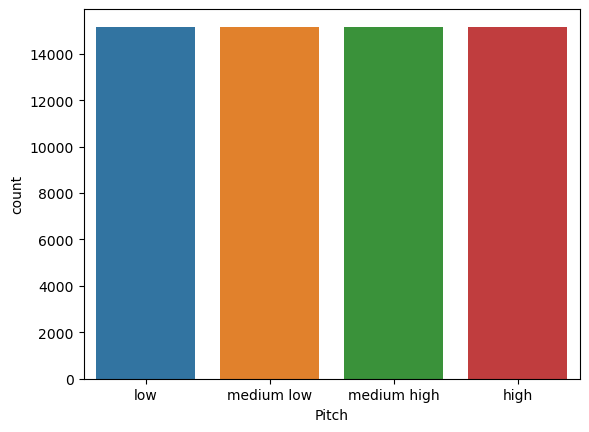

In [7]:
range_counts = df2['Pitch'].value_counts()

sns.barplot(x=range_counts.index, y=range_counts.values)

plt.ylabel('count')

Now I will trim down our dataset to all of the face landmark features, as well as the pitch column that we want to use as a target. The other hundreds of columns are not being examined in this notebook.

In [8]:
#grab only columns that are face landmarks
list_columns = df2.columns.to_list()

good_cols = []
for col in list_columns:
    if 'face' in col:
        good_cols.append(col)

#also want the pitch column as a target
good_cols.append('Pitch')

df2 = df2[good_cols]

#drop rows with any null values
df2 = df2.dropna()

### Machine Learning Models

Now we start to build our models: the goal is to predict the pitch categorization the participant is singing at using the face landmark data. 

First attempt: set up a basic grid search for random forest and knn to get a baseline of accuracy achievable. Note we are limited by computational speed due to the hundreds of columns so I trimmed the searching parameters down to a relatively simple set of combinations. First we will scale our features, then apply train test split, and finally run a Knn and Rf model with basic hyper parameter tuning.

In [9]:
#create target and feature columns
target = df2['Pitch']
inputs = df2.drop(columns = ['Pitch'])

#standardize feature columns
scaler = StandardScaler()
scaled_inputs = scaler.fit_transform(inputs)

#train test split with 20% testing
X_train, X_test, y_train, y_test = train_test_split(scaled_inputs, target ,test_size=0.2)

In [10]:
# prevent warnings from appearing
import warnings
warnings.filterwarnings('ignore')

#establish parameter grid for tuning
knn_param_grid = {
    'n_neighbors': [2, 5],
    'metric': ['euclidean', 'manhattan']
}

rf_param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [10, 50]
}

def grid_search_model(model, param_grid, train_X, train_y, model_name, pca = False):
    '''
    The function performs grid search to identify optimal parameters based on training data,
    evaluates this function on testing data over 5 new splits, and prints the details and accuracy
    of the best model.
    
    Note later this function will be called for a use case with pca, so the "pca" bool is an indicator
    of if the function is being called for this use case or the pca use case.
    '''
    # set model paramaters using grid search
    search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', verbose = 0)
        
    # Fit the grid search
    search.fit(train_X, train_y)
    
    # Get the best parameters
    best_params = search.best_params_
    
    #Get the best model
    best_model = search.best_estimator_
    
    # Evaluate the best model on the test data
    test_accuracy = cv_accuracy(best_model, param_grid, pca)
    
    # print parameters and scores
    print(f"Model: {model_name}")
    print(f"Best Parameters: {best_params}")
    print(f"Test Accuracy Averaged Over 5 Splits: {test_accuracy: .2f}")
    
    return best_model

def cv_accuracy(best_model, param_grid, pca):
    '''
    Takes in a model with defined parameters and re-preforms train, test, split on the dataset 5 times.
    For each split, it fits the model on training data and then scores the model on testing data.
    Then, the average score from each of the splits is returned.
    '''
    scores = []
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(scaled_inputs, target ,test_size=0.2)
        
        # apply pca to the new split of data for the pca use case
        if pca == True:
            X_train = pca_four.fit_transform(X_train)
            X_test = pca_four.transform(X_test)
            
        best_model.fit(X_train, y_train)
        scores.append(best_model.score(X_test, y_test))
    return np.mean(scores)

#Create and evaluate knn and rf models using functions above
best_knn = grid_search_model(KNeighborsClassifier(), knn_param_grid, X_train, y_train, 'knn' )
best_rf = grid_search_model(RandomForestClassifier(), rf_param_grid, X_train, y_train, 'random forest' )

Model: knn
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 2}
Test Accuracy Averaged Over 5 Splits:  0.88
Model: random forest
Best Parameters: {'max_depth': 50, 'n_estimators': 100}
Test Accuracy Averaged Over 5 Splits:  0.90


These testing results are very high! Since we started with an even split of all four groups, an untrained model should score around 25% so I am very happy with the model's ability and it has clearly learned a lot from the data. On cross validation: the testing accuracy is an average over 5 new splits of testing data, and the gridsearch by default uses a 5 fold cv as well to choose the model parameters.

### PCA

To reduce computational cost and speed since we are working with over 200 feature columns and this makes it time consuming to train models, we will try dimension reduction using PCA. We will try to reduce the features to a maximum of 8 components and see how much information can still be captured at each stage of components.

Text(0, 0.5, 'Cumulative Explained Variance Ratio')

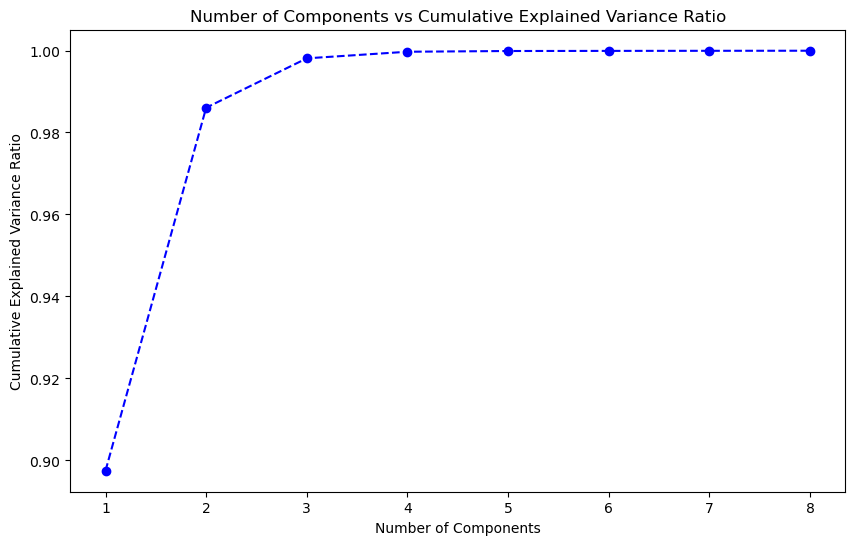

In [11]:
# Call PCA command on training data
pca = PCA(n_components = 8) # creating an algorithm to conduct PCA with 8 principle components

# fit to the training data
X_train_pca = pca.fit_transform(X_train)

#grab cumulative explained variance ratio
cum_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot number of components vs cumulative explained variance ratio
plt.figure(figsize = (10, 6))
plt.plot(range(1, len(cum_ratio) + 1), cum_ratio, marker = 'o', linestyle = '--', color = 'b')

plt.title('Number of Components vs Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')


These results are very good, they tell us that if we reduce to 4 components we have almost the entire full data complexity still captured. We will do this reduction to improve our model speed greatly.

In [12]:
# Perform PCA with 4 principal components
pca_four = PCA(n_components = 4)

# fit to the training data and testing data
X_train_pca = pca_four.fit_transform(X_train)
X_test_pca = pca_four.transform(X_test)

print ('Explained variance with 4 principal components is:', cum_ratio[3] )

Explained variance with 4 principal components is: 0.999697980870937


Now try a more detailed gridsearch to tune knn and rf parameters on our revised dataset with pca applied. We will see if our models can reach similar accuracies with our four component summary, as with all the features.

In [13]:
warnings.filterwarnings('ignore')

#define parameter grids
knn_param_grid_long = {
    'n_neighbors': [2, 3, 5, 10, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

rf_param_grid_long = {
    'n_estimators': [20, 50, 100, 200],
    'max_depth': [5, 10, 30, 50],
    'criterion': ['gini', 'entropy']
}

#Perform grid search and evaluate model using function defined above
#note this time the pca indicator is set to true to indicate we are on this use case
best_knn_pca = grid_search_model(KNeighborsClassifier(), knn_param_grid_long, X_train_pca, y_train, 'knn', True )
best_rf_pca = grid_search_model(RandomForestClassifier(), rf_param_grid_long, X_train_pca, y_train, 'random forest', True )

Model: knn
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
Test Accuracy Averaged Over 5 Splits:  0.82
Model: random forest
Best Parameters: {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 200}
Test Accuracy Averaged Over 5 Splits:  0.81


We see that with 4 principal components instead of hundreds of features, the models still perform well at over 80% testing accuracy. We did lose just a few percentages in comparison to the model trained on the full dataset, but it came at the tradeoff of much quicker and less expensive computation so this is another positive result.

# Feature Exploration

Now we will tackle feature selection to explore...
1) Is there a more efficient number of features to use for our model besides taking in all hundreds of face landmarks that can yield similarly high accuracies?
2) Which facial features are the best indicators of pitch, what exactly changes in one's face when singing different notes?

First identify the most correlated features with the pitch classification according to SelectKBest algorithm. This is a univariate approach where each feature is evaluated individually in comparison to the target column, and the highest statistically significant relationships are selected.

In [45]:
selector = SelectKBest(f_classif, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get the mask of selected features
mask = selector.get_support()

# Get the names of the selected features
selected_feature_names = inputs.columns[mask]

#Output as a list
print(f"Selected features:")
selected_list = selected_feature_names.tolist()
for name in selected_list:
    print (name)

Selected features:
phone_face_landmark_11_x
phone_face_landmark_12_x
phone_face_landmark_13_x
phone_face_landmark_14_x
phone_face_landmark_15_x
phone_face_landmark_16_x
phone_face_landmark_17_x
phone_face_landmark_26_x
phone_face_landmark_27_x
phone_face_landmark_46_x


Compare this with the most informative features for our 'best' random forest model after it is fit to a training split. This time this is a multivariate approach that takes in the feature's relationships with each other and their overall ability to improve model accuracy.

In [55]:
X_train, X_test, y_train, y_test = train_test_split(scaled_inputs, target ,test_size=0.2)

best_rf.fit(X_train, y_train)

importances = best_rf.feature_importances_

indices = np.argsort(importances)[::-1]  #sort highest to lowest

list_cols = inputs.columns.to_list()

# Print feature ranking
print ('Features from most to least important:')
for i in range(10):
    print(f"{i + 1}. {list_cols[indices[i]]}")

Features from most to least important:
1. phone_face_landmark_38_y
2. phone_face_landmark_45_y
3. phone_face_landmark_17_y
4. phone_face_landmark_44_y
5. phone_face_landmark_10_y
6. phone_face_landmark_27_y
7. phone_face_landmark_1_y
8. phone_face_landmark_11_y
9. phone_face_landmark_26_y
10. phone_face_landmark_19_y


The following is the code from the dlib library of what each facial landmark number corresponds to:

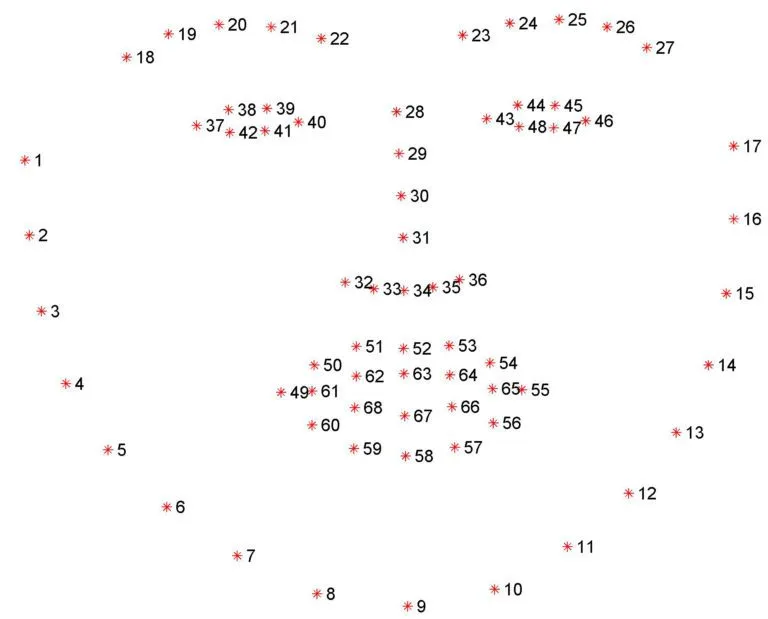

It makes sense that the univariate feature selection vs multivariate yield different results because they are looking at different things to define importance. The individual approach indicates that the jaw/cheek points (specifically on the right side likely due to recording angle) appear to have a strong influence on pitch when taken by themselves. The rf model analysis contains more scattered points, but notably the top  importance features are the two top of eye landmark on each side of the face which shows the eyes are probably getting wider and narrower through the progression of pitches. Additionally, both lists include 26 and 27 which are two eyebrow points, so this seems like another strong indicator

Now we will see if our model can still perform well after selecting only some of the features. I will experiment by testing the rf model on the top 3 most important features up to the top 50 features, stepping by 5 for the sake of time

Text(0, 0.5, 'RF model testing accuracy')

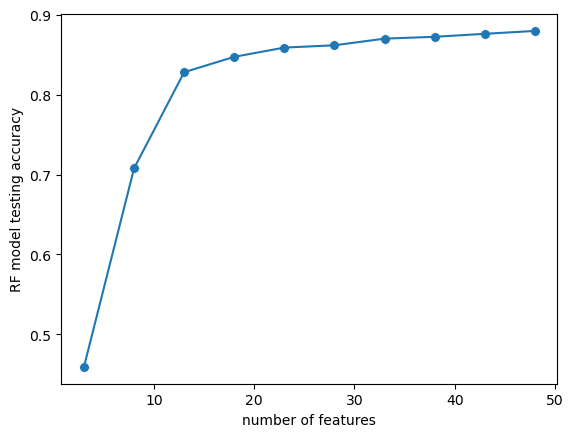

In [60]:
def score_for_select_indices(num):

    top_indices = indices[:num]  # Select the top indices up to value indicated

    # Transform the datasets to include only the selected features
    X_train_selected = X_train[:, top_indices]
    X_test_selected = X_test[:, top_indices]

    best_rf.fit(X_train_selected, y_train)
    return best_rf.score(X_test_selected, y_test)

#score model on differing numbers of top indices selected
scores = []
for i in range(3,50,5):
    scores.append(score_for_select_indices(i))

#plot score results
sns.lineplot(x = range (3,50,5), y = scores)
sns.scatterplot(x = range (3,50,5), y = scores, s = 50)

plt.xlabel('number of features')
plt.ylabel('RF model testing accuracy')

The graph indicates that the first approximately 15 importance features are capable of achieving almost all of the model's possible accuracy. After this initial steep rise, the testing accuracy does slowly increase and creep towards the ~90% accuracy achieved previously with the full dataset as more features are added, which makes a lot of logical sense

# Conclusions

Our models were very successful in classifying singing pitch based on facial landmark features. After splitting into four quartiles of pitch range, our random forest model achieved the highest testing accuracy in categorizing into these four groups at around a 90% score verified by cross validation. 

Additionally, the data stood up well to dimension reduction. When using PCA to condense the features into only four dimensions the models were each still able to score over 80% accuracy. Similarly, when using feature selection we observed that with roughly the 15 most important features the random forest model was again testing at a mid 80% accuracy.

Although there were many scattered influential points on the face, it appeared that the landmarks located at the top of the participants eyes, the jaw/cheek, and the eyebrow may be most informative in indicating what pitch is being sung.